# 02 – Differential Expression Analysis (DESeq2)

📓 This notebook:

- Loads the processed count matrix and metadata
- Runs DESeq2 to compare **CD44_high** vs **CD44_low**
- Exports the full DESeq2 results table back to Python
- Generates and saves a volcano plot
- Saves the DE results as a CSV under `results/`


In [ ]:
# ---------------------------------------------------------------------
# Define base directories used across the analysis.
# Assumes this notebook is in: notebooks/
# ---------------------------------------------------------------------
import pandas as pd
from pathlib import Path

BASE_DIR = Path("..").resolve()
DATA_PROCESSED = BASE_DIR / "data" / "processed"
RESULTS_DIR = BASE_DIR / "results"
FIG_DIR = BASE_DIR / "figures"

# Make sure output folders exist
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Paths to preprocessed data from notebook 01
counts_path = DATA_PROCESSED / "GSE113660_counts.csv"
metadata_path = DATA_PROCESSED / "GSE113660_metadata.csv"

# Load gene × sample count matrix and sample metadata
counts = pd.read_csv(counts_path, index_col=0)
metadata = pd.read_csv(metadata_path)
metadata = metadata.set_index("sample")

print(counts.shape)
print(metadata.shape)
metadata.head()


(33572, 9)
(9, 1)


,condition
sample,
SJRHB046412_C1,unsorted
SJRHB046412_C2,CD44_high
SJRHB046412_C3,CD44_low
SJRHB046412_C4,CD44_low
SJRHB046412_C5,CD44_low


In [2]:
# ---------------------------------------------------------------------
# Enable R inside this notebook using rpy2.
# This allows us to call DESeq2 (R package) directly from Python.
# ---------------------------------------------------------------------
%load_ext rpy2.ipython

In [3]:
%%R -i counts -i metadata

# ---------------------------------------------------------------------
# DESeq2 differential expression analysis in R
#
# Input:
#   - counts: gene × sample matrix (integer counts)
#   - metadata: data frame with a 'condition' column
#
# Comparison:
#   CD44_high vs CD44_low
# ---------------------------------------------------------------------

suppressPackageStartupMessages(library(DESeq2))

# Convert condition column to a factor to avoid downstream issues
metadata$condition <- factor(metadata$condition)

# Select only CD44_high vs CD44_low samples
# Unsorted samples are excluded from DE analysis
keep <- metadata$condition %in% c("CD44_high", "CD44_low")
counts_sub <- counts[, keep]
metadata_sub <- metadata[keep,, drop=FALSE]

# Validate matching order
print(all(colnames(counts_sub) == rownames(metadata_sub)))

# Create DESeq2 dataset object
dds <- DESeqDataSetFromMatrix(
    countData = round(counts_sub),
    colData = metadata_sub,
    design = ~ condition
)

# Filter low-count genes (DESeq2 recommended prefiltering)
# Keeps genes with at least 10 total reads
keep_genes <- rowSums(counts(dds)) >= 10
dds <- dds[keep_genes, ]

# Run DESeq2 pipeline
dds <- DESeq(dds)

# Extract results for contrast: CD44_high vs CD44_low
res <- results(dds, contrast = c("condition", "CD44_high", "CD44_low"))
res_df <- as.data.frame(res)

[1] TRUE


converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [4]:
%%R -o res_df
res_df

                           baseMean log2FoldChange      lfcSE          stat
7SK                    4.470024e+02  -0.2549095715 0.25635658 -9.943555e-01
A1BG                   4.886467e+01   0.9624458459 0.44097990  2.182516e+00
A1BG-AS1               7.153068e+02   0.2316203728 0.12740442  1.817993e+00
A2M-AS1                3.800785e+01  -1.2448031910 0.41184965 -3.022470e+00
A3GALT2                3.059810e+01   0.0517033366 0.66150597  7.816004e-02
A4GALT                 4.760577e+01   1.3602408014 0.39188900  3.470985e+00
A4GNT                  2.293390e+00  -1.8786929020 1.48622608 -1.264069e+00
AAAS                   2.934067e+03   0.1280442041 0.13599428  9.415411e-01
AACS                   3.297044e+03  -0.5978031362 0.28705951 -2.082506e+00
AADAT                  1.278393e+03  -0.3517914031 0.10050182 -3.500348e+00
AAED1                  5.957939e+02   0.2899942939 0.31120249  9.318508e-01
AAGAB                  2.734641e+03   0.0204165740 0.11377995  1.794391e-01
AAK1        

In [5]:
import pandas as pd
from pathlib import Path

# ---------------------------------------------------------------------
# Bring DESeq2 results back into Python and save to CSV.
# ---------------------------------------------------------------------
BASE_DIR = Path("..").resolve()
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

df = res_df.copy()
print(df.shape)
df.head()


# Save DESeq2 results
out_path = RESULTS_DIR / "GSE113660_deseq2_results.csv"
df.to_csv(out_path)
out_path


(22115, 6)


PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/results/GSE113660_deseq2_results.csv')

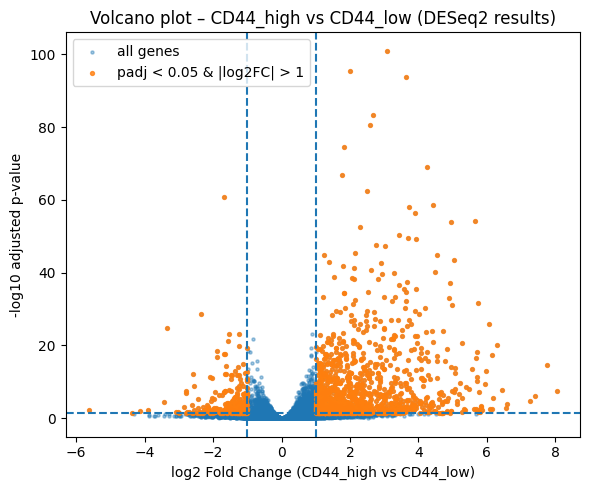

PosixPath('/Users/melikagr/bioinformatics-projects/GSE113660-cd44-rnaseq-analysis/figures/volcano_CD44_high_vs_low.png')

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------------------------------------------------
# Volcano plot of DESeq2 results:
#   x-axis: log2 fold change (CD44_high vs CD44_low)
#   y-axis: –log10(adjusted p-value)
# Highlight genes with:
#   padj < 0.05 AND |log2FC| > 1
# ---------------------------------------------------------------------
df = res_df.copy()
df = df.dropna(subset=["padj"]) # remove genes without adjusted p-value

x = df["log2FoldChange"]
y = -np.log10(df["padj"])

plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.4, label="all genes")

# Significance criteria
sig = (df["padj"] < 0.05) & (df["log2FoldChange"].abs() > 1)
plt.scatter(x[sig], y[sig], s=8, alpha=0.8, label="padj < 0.05 & |log2FC| > 1")

plt.axvline(1, linestyle="--")
plt.axvline(-1, linestyle="--")
plt.axhline(-np.log10(0.05), linestyle="--")

plt.xlabel("log2 Fold Change (CD44_high vs CD44_low)")
plt.ylabel("-log10 adjusted p-value")
plt.title("Volcano plot – CD44_high vs CD44_low (DESeq2 results)")
plt.legend()
plt.tight_layout()

fig_path = FIG_DIR / "volcano_CD44_high_vs_low.png"
plt.savefig(fig_path, dpi=300)
plt.show()

fig_path
